In [100]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from matplotlib.colors import LinearSegmentedColormap
from scipy.io import loadmat
from skimage.measure import regionprops
import os
from PIL import Image

In [101]:
os.chdir('.\one_hum')

FileNotFoundError: [WinError 2] The system cannot find the file specified: '.\\one_hum'

In [102]:
def SegmentBodyPart(bodyPart, i):
    '''
    Crops body parts from a given image based on mask and boundary boxes.
    bodyPart: Name of the body part to be cropped
    i: index of file to be cropped
    
    '''

    #get colormap from dataset
    def color_map(N=256, normalized=True, matplotlib=True):
        def bitget(byteval, idx):
            return ((byteval & (1 << idx)) != 0)

        dtype = 'float32' if normalized else 'uint8'
        cmap = np.zeros((N, 3), dtype=dtype)
        for i in range(N):
            r = g = b = 0
            c = i
            for j in range(8):
                r = r | (bitget(c, 0) << 7-j)
                g = g | (bitget(c, 1) << 7-j)
                b = b | (bitget(c, 2) << 7-j)
                c = c >> 3

            cmap[i] = np.array([r, g, b])

        cmap = cmap/255 if normalized else cmap
        if matplotlib:
            assert(normalized is True)
            return LinearSegmentedColormap.from_list('VOClabel_cmap', cmap)
        else:
            return cmap

    #get colormaps from each classes of objects
    def color_map_viz():
        labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                  'bottle', 'bus', 'car', 'cat', 'chair',
                  'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                  'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
        nclasses = 21
        row_size = 50
        col_size = 500
        cmap = color_map()
        array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
        for i in range(nclasses):
            array[i*row_size:i*row_size+row_size, :] = cmap[i]
        array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]

        imshow(array)
        plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
        plt.xticks([])
        plt.show()
    
    ''' 
    Get class names and part names associated with each class
    Define the part index of each objects.
    One can merge different parts by using the same index for the
    parts that are desired to be merged.
    For example, one can merge
    the left lower leg (llleg) and the left upper leg (luleg) of person by setting:
    pimap[15]['llleg']      = 19;               # left lower leg
    pimap[15]['luleg']      = 19;               # left upper leg
    '''


    def get_class_names():
        classes = {1: 'aeroplane',
                   2: 'bicycle',
                   3: 'bird',
                   4: 'boat',
                   5: 'bottle',
                   6: 'bus',
                   7: 'car',
                   8: 'cat',
                   9: 'chair',
                   10: 'cow',
                   11: 'table',
                   12: 'dog',
                   13: 'horse',
                   14: 'motorbike',
                   15: 'person',
                   16: 'pottedplant',
                   17: 'sheep',
                   18: 'sofa',
                   19: 'train',
                   20: 'tvmonitor'}
        return classes


    def get_pimap():
        pimap = {}

        # [aeroplane]
        pimap[1] = {}
        pimap[1]['body']        = 1
        pimap[1]['stern']       = 2
        pimap[1]['lwing']       = 3                # left wing
        pimap[1]['rwing']       = 4                # right wing
        pimap[1]['tail']        = 5
        for ii in range(1, 10 + 1):
            pimap[1][('engine_%d' % ii)] = 10+ii # multiple engines
        for ii in range(1, 10 + 1):
            pimap[1][('wheel_%d' % ii)] = 20+ii  # multiple wheels

        # [bicycle]
        pimap[2] = {}
        pimap[2]['fwheel']      = 1                # front wheel
        pimap[2]['bwheel']      = 2                # back wheel
        pimap[2]['saddle']      = 3
        pimap[2]['handlebar']   = 4                # handle bar
        pimap[2]['chainwheel']  = 5                # chain wheel
        for ii in range(1, 10 + 1):
            pimap[2][('headlight_%d' % ii)] = 10 + ii

        # [bird]
        pimap[3] = {}
        pimap[3]['head']        = 1
        pimap[3]['leye']        = 2                # left eye
        pimap[3]['reye']        = 3                # right eye
        pimap[3]['beak']        = 4
        pimap[3]['torso']       = 5
        pimap[3]['neck']        = 6
        pimap[3]['lwing']       = 7                # left wing
        pimap[3]['rwing']       = 8                # right wing
        pimap[3]['lleg']        = 9                # left leg
        pimap[3]['lfoot']       = 10               # left foot
        pimap[3]['rleg']        = 11               # right leg
        pimap[3]['rfoot']       = 12               # right foot
        pimap[3]['tail']        = 13

        # [boat]
        # only has silhouette mask

        # [bottle]
        pimap[5] = {}
        pimap[5]['cap']         = 1
        pimap[5]['body']        = 2

        # [bus]
        pimap[6] = {}
        pimap[6]['frontside']   = 1
        pimap[6]['leftside']    = 2
        pimap[6]['rightside']   = 3
        pimap[6]['backside']    = 4
        pimap[6]['roofside']    = 5
        pimap[6]['leftmirror']  = 6
        pimap[6]['rightmirror'] = 7
        pimap[6]['fliplate']    = 8                # front license plate
        pimap[6]['bliplate']    = 9                # back license plate
        for ii in range(1, 10 + 1):
            pimap[6][('door_%d' % ii)] = 10 + ii
        for ii in range(1, 10 + 1):
            pimap[6][('wheel_%d' % ii)] = 20 + ii
        for ii in range(1, 10 + 1):
            pimap[6][('headlight_%d' % ii)] = 30 + ii
        for ii in range(1, 20 + 1):
            pimap[6][('window_%d' % ii)] = 40 + ii

        # [car]
        pimap[7] = pimap[6].copy()         # car has the same set of parts with bus

        # [cat]
        pimap[8] = {}
        pimap[8]['head']        = 1
        pimap[8]['leye']        = 2                # left eye
        pimap[8]['reye']        = 3                # right eye
        pimap[8]['lear']        = 4                # left ear
        pimap[8]['rear']        = 5                # right ear
        pimap[8]['nose']        = 6
        pimap[8]['torso']       = 7
        pimap[8]['neck']        = 8
        pimap[8]['lfleg']       = 9                # left front leg
        pimap[8]['lfpa']        = 10               # left front paw
        pimap[8]['rfleg']       = 11               # right front leg
        pimap[8]['rfpa']        = 12               # right front paw
        pimap[8]['lbleg']       = 13               # left back leg
        pimap[8]['lbpa']        = 14               # left back paw
        pimap[8]['rbleg']       = 15               # right back leg
        pimap[8]['rbpa']        = 16               # right back paw
        pimap[8]['tail']        = 17

        # [chair]
        # only has sihouette mask

        # [cow]
        pimap[10] = {}
        pimap[10]['head']       = 1
        pimap[10]['leye']       = 2                # left eye
        pimap[10]['reye']       = 3                # right eye
        pimap[10]['lear']       = 4                # left ear
        pimap[10]['rear']       = 5                # right ear
        pimap[10]['muzzle']     = 6
        pimap[10]['lhorn']      = 7                # left horn
        pimap[10]['rhorn']      = 8                # right horn
        pimap[10]['torso']      = 9
        pimap[10]['neck']       = 10
        pimap[10]['lfuleg']     = 11               # left front upper leg
        pimap[10]['lflleg']     = 11               # left front lower leg
        pimap[10]['rfuleg']     = 12               # right front upper leg
        pimap[10]['rflleg']     = 12               # right front lower leg
        pimap[10]['lbuleg']     = 15               # left back upper leg
        pimap[10]['lblleg']     = 16               # left back lower leg
        pimap[10]['rbuleg']     = 17               # right back upper leg
        pimap[10]['rblleg']     = 18               # right back lower leg
        pimap[10]['tail']       = 19

        # [table]
        # only has silhouette mask

        # [dog]
        pimap[12] = pimap[8].copy()         	# dog has the same set of parts with cat,
                                                # except for the additional
                                                # muzzle
        pimap[12]['muzzle']     = 20

        # [horse]
        pimap[13] = pimap[10].copy()        	# horse has the same set of parts with cow,
                                                # except it has hoof instead of horn
        del pimap[13]['lhorn']
        del pimap[13]['rhorn']
        pimap[13]['lfho'] = 30
        pimap[13]['rfho'] = 31
        pimap[13]['lbho'] = 32
        pimap[13]['rbho'] = 33

        # [motorbike]
        pimap[14] = {}
        pimap[14]['fwheel']     = 1
        pimap[14]['bwheel']     = 2
        pimap[14]['handlebar']  = 3
        pimap[14]['saddle']     = 4
        for ii in range(1, 10 + 1):
            pimap[14][('headlight_%d' % ii)] = 10 + ii

        # [person]
        pimap[15] = {}
        pimap[15]['head']       = 1
        pimap[15]['leye']       = 2                    # left eye
        pimap[15]['reye']       = 3                    # right eye
        pimap[15]['lear']       = 4                    # left ear
        pimap[15]['rear']       = 5                    # right ear
        pimap[15]['lebrow']     = 6                    # left eyebrow
        pimap[15]['rebrow']     = 7                    # right eyebrow
        pimap[15]['nose']       = 8
        pimap[15]['mouth']      = 9
        pimap[15]['hair']       = 10

        pimap[15]['torso']      = 11
        pimap[15]['neck']       = 12
        pimap[15]['llarm']      = 13                   # left lower arm
        pimap[15]['luarm']      = 13                   # left upper arm
        pimap[15]['lhand']      = 14                   # left hand
        pimap[15]['rlarm']      = 15                   # right lower arm
        pimap[15]['ruarm']      = 15                   # right upper arm
        pimap[15]['rhand']      = 16                   # right hand

        pimap[15]['llleg']      = 17               	# left lower leg
        pimap[15]['luleg']      = 17               	# left upper leg
        pimap[15]['lfoot']      = 18               	# left foot
        pimap[15]['rlleg']      = 19               	# right lower leg
        pimap[15]['ruleg']      = 19               	# right upper leg
        pimap[15]['rfoot']      = 20               	# right foot

        # [pottedplant]
        pimap[16] = {}
        pimap[16]['pot']        = 1
        pimap[16]['plant']      = 2

        # [sheep]
        pimap[17] = pimap[10].copy()        # sheep has the same set of parts with cow

        # [sofa]
        # only has sihouette mask

        # [train]
        pimap[19] = {}
        pimap[19]['head']       = 1
        pimap[19]['hfrontside'] = 2                	# head front side
        pimap[19]['hleftside']  = 3                	# head left side
        pimap[19]['hrightside'] = 4                	# head right side
        pimap[19]['hbackside']  = 5                 # head back side
        pimap[19]['hroofside']  = 6                	# head roof side

        for ii in range(1, 10 + 1):
            pimap[19][('headlight_%d' % ii)] = 10 + ii

        for ii in range(1, 10 + 1):
            pimap[19][('coach_%d' % ii)] = 20 + ii

        for ii in range(1, 10 + 1):
            pimap[19][('cfrontside_%d' % ii)] = 30 + ii   # coach front side

        for ii in range(1, 10 + 1):
            pimap[19][('cleftside_%d' % ii)] = 40 + ii   # coach left side

        for ii in range(1, 10 + 1):
            pimap[19][('crightside_%d' % ii)] = 50 + ii  # coach right side

        for ii in range(1, 10 + 1):
            pimap[19][('cbackside_%d' % ii)] = 60 + ii   # coach back side

        for ii in range(1, 10 + 1):
            pimap[19][('croofside_%d' % ii)] = 70 + ii   # coach roof side


        # [tvmonitor]
        pimap[20] = {}
        pimap[20]['screen']     = 1

        return pimap
    


    #get parts map
    PIMAP = get_pimap()

    #get Image Annotations
    class ImageAnnotation(object):
        
        def __init__(self, impath, annopath):
            # read image
            self.im = imread(impath)
            self.impath = impath
            self.imsize = self.im.shape

            # read annotations
            data = loadmat(annopath)['anno'][0, 0]
            self.imname = data['imname'][0]
            self.annopath = annopath

            # parse objects and parts
            self.n_objects = data['objects'].shape[1]
            self.objects = []
            for obj in data['objects'][0, :]:
                self.objects.append(PascalObject(obj))

            # create masks for objects and parts
            self._mat2map()

        def _mat2map(self):
            ''' Create masks from the annotations
            Python implementation based on
            http://www.stat.ucla.edu/~xianjie.chen/pascal_part_dataset/trainval.tar.gz
            Read the annotation and present it in terms of 3 segmentation mask maps (
            i.e., the class maks, instance maks and part mask). pimap defines a
            mapping between part name and index (See part2ind.py).
            '''
            shape = self.imsize[:-1]  # first two dimensions, ignore color channel
            self.cls_mask = np.zeros(shape, dtype=np.uint8)
            self.inst_mask = np.zeros(shape, dtype=np.uint8)
            self.part_mask = np.zeros(shape, dtype=np.uint8)

            ######Get one part mask
            self.one_part_mask = np.zeros(shape, dtype=np.uint8)
            ######

            for i, obj in enumerate(self.objects):
                class_ind = obj.class_ind
                mask = obj.mask

                self.inst_mask[mask > 0] = i + 1
                self.cls_mask[mask > 0] = class_ind

                if obj.n_parts > 0:
                    for p in obj.parts:
                        part_name = p.part_name
                        pid = PIMAP[class_ind][part_name]
                        self.part_mask[p.mask > 0] = pid


                        #####part mask for specified body part
                        if part_name in bodyPart:
                          self.one_part_mask[p.mask > 0] = pid
                        
                        #####



    class PascalBase(object):
        def __init__(self, obj):
            self.mask = obj['mask']
            self.props = self._get_region_props()

        def _get_region_props(self):
            ''' useful properties
            It includes: area, bbox, bbox_Area, centroid
            It can also extract: filled_image, image, intensity_image, local_centroid
            '''
            return regionprops(self.mask)[0]


    class PascalObject(PascalBase):
        def __init__(self, obj):
            super(PascalObject, self).__init__(obj)

            self.class_name = obj['class'][0]
            self.class_ind = obj['class_ind'][0, 0]

            self.n_parts = obj['parts'].shape[1]
            self.parts = []
            if self.n_parts > 0:
                for part in obj['parts'][0, :]:
                    self.parts.append(PascalPart(part))


    class PascalPart(PascalBase):
        def __init__(self, obj):
            super(PascalPart, self).__init__(obj)
            self.part_name = obj['part_name'][0]
    
    #get files from given directory
    destdir = './'
    files = [ f for f in os.listdir(destdir) if os.path.isfile(os.path.join(destdir,f)) ]

    #separate images and annotations
    ims = []
    annos = []
    for f in files:
      if f[-3:] == 'jpg':
        ims.append(f)
      elif f[-3:] == 'mat':
        annos.append(f)
    
    #get segmented image and save it
    fname_anno = annos[i]
    fname_im = ims[i]

    an = ImageAnnotation(fname_im, fname_anno)
    
    part_mask = an.part_mask
    
    an = ImageAnnotation(fname_im, fname_anno)

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(an.im)
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(an.cls_mask, cmap=color_map(N=np.max(an.cls_mask) + 1))
    ax2.set_title('Class mask')
    ax2.axis('off')
    ax3.imshow(an.inst_mask, cmap=color_map(N=np.max(an.inst_mask) + 1))
    ax3.set_title('Instance mask')
    ax3.axis('off')
    if np.max(an.part_mask) == 0:
        ax4.imshow(an.part_mask, cmap='gray')
    else:
        ax4.imshow(an.part_mask, cmap=color_map(N=np.max(an.part_mask) + 1))
    ax4.set_title('Part mask')
    ax4.axis('off')
    plt.savefig('C:/Users/klab/Desktop/cropped_ims/' + str(i) + '_masks')
    
    #apply one part mask
    from PIL import Image
    one_mask1 = an.one_part_mask
    
    #one_mask = Image.fromarray(one_mask1)
    #one_mask.save('one_mask_' + str(parts[i]) + '_' +'.png')

    w, h = one_mask1.shape
    #plt.imshow(one_mask1)
    #plt.savefig('./' + bodyPart)
    
    one_mask_flat = one_mask1.flatten()
    ind_nz = np.flatnonzero(one_mask_flat)
    
    y_coor = []
    x_coor = []

    for x in ind_nz:
        y0 = x // h
        x0 = x % h

        x_coor.append(x0)
        y_coor.append(y0)

    x1 = min(x_coor)
    y1 = min(y_coor)

    x2 = max(x_coor)
    y2 = max(y_coor)

    print('Upper left corner coordinates are:' , x1, ',', y1 )
    print('Lower right corner coordinates are:' , x2, ',', y2 )

    from PIL import Image
    imageObject = Image.open(ims[i])

    cropped = imageObject.crop((x1,y1,x2,y2))

    #plt.imshow(cropped)
    cropped.save('C:/Users/klab/Desktop/cropped_ims/' + str(i) + 'cropped_im_'  + '_' + bodyPart[0] + '.png')

In [103]:
parts = [['head'], ['torso'], ['llarm', 'luarm'], ['ruarm', 'rlarm'], ['rhand'], ['lhand'], ['luleg', 'llleg'], ['ruleg', 'rlleg']]

Upper left corner coordinates are: 77 , 10
Lower right corner coordinates are: 173 , 121
Upper left corner coordinates are: 99 , 72
Lower right corner coordinates are: 249 , 223
Upper left corner coordinates are: 142 , 71
Lower right corner coordinates are: 227 , 203
Upper left corner coordinates are: 42 , 95
Lower right corner coordinates are: 103 , 154
Upper left corner coordinates are: 83 , 143
Lower right corner coordinates are: 121 , 190
Upper left corner coordinates are: 104 , 180
Lower right corner coordinates are: 144 , 208
Upper left corner coordinates are: 162 , 194
Lower right corner coordinates are: 278 , 425
Upper left corner coordinates are: 121 , 211
Lower right corner coordinates are: 201 , 391


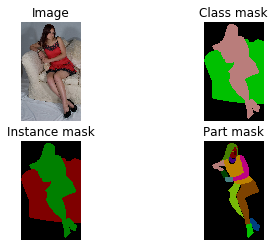

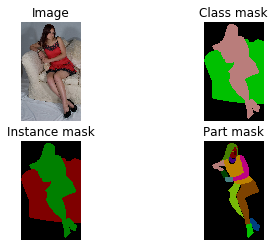

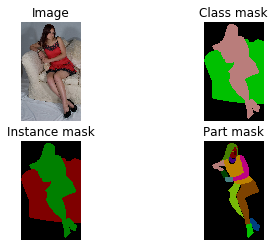

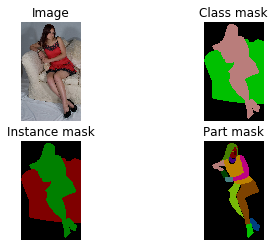

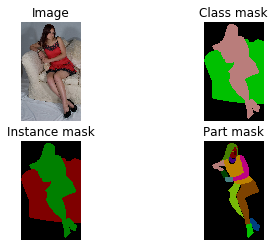

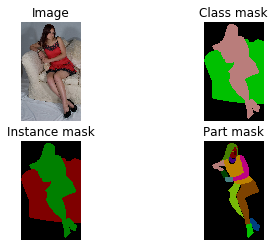

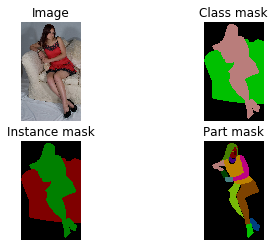

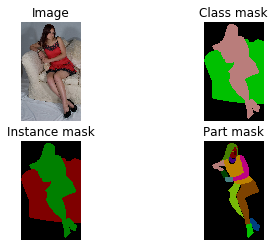

In [104]:
for bodyPart in parts:
    SegmentBodyPart(bodyPart, 0)